# Quick Start: Polymer Field Theory in 5 Minutes

This tutorial provides a rapid introduction to `polymerfts` for polymer field theory simulations.

**What you'll learn:**
- How to compute chain propagators
- How to calculate polymer concentrations
- Basic visualization of results

**Prerequisites:** Basic Python and NumPy knowledge. Basic polymer physics experience required.

## 1. Setup

First, import the necessary libraries:

In [3]:
import os
os.environ["OMP_NUM_THREADS"] = "1"      # Optimize threading
os.environ["OMP_NUM_THREADS"] = "1"      # Single-threaded FFTW

import numpy as np
import matplotlib.pyplot as plt
from polymerfts import PropagatorSolver

print("polymerfts imported successfully!")

polymerfts imported successfully!


## 2. Your First Simulation: A Simple Homopolymer

Let's simulate a homopolymer (a chain made of identical monomers) in a 1D domain.

### Key Concepts

**Units in polymer field theory:**
- Length is measured in units of $R_0 = b\sqrt{N}$ (the unperturbed end-to-end distance)
- Here $b$ is the statistical segment length and $N$ is the reference chain length
- The contour parameter $s$ runs from 0 to 1 along the chain (0 = one end, 1 = other end)

**The contour step `ds`:**
- With `ds = 0.01`, the chain is discretized into 100 segments
- Smaller `ds` gives higher accuracy but takes longer to compute
- Typical values: 0.005 to 0.02

### Step 1: Create a Solver

The `PropagatorSolver` handles all the complex setup for you:

In [4]:
# Create a 1D solver
solver = PropagatorSolver(
    nx=[64],        # 64 grid points
    lx=[4.0],       # Domain length = 4.0 (in units of polymer size)
    ds=0.01,        # Contour step size
    bond_lengths={"A": 1.0},  # Monomer type "A" with bond length 1.0
    platform="cpu-fftw"  # Explicitly use CPU
)

# Add a homopolymer chain
solver.add_polymer(
    volume_fraction=1.0,
    blocks=[["A", 1.0, 0, 1]]  # Single block of type A, length 1.0
)

# Create potential and set fields immediately
x = np.linspace(0, 4.0, 64)
w_A = 5.0 * (x - 2.0)**2 - 5.0  # Parabolic well centered at x=2
solver.set_fields({"A": w_A})

print("Solver created and initialized successfully!")
print(solver.info)

Solver created and initialized successfully!
PropagatorSolver Configuration:
  Dimensions: 1D
  Grid: [64]
  Box size: [4.0]
  Boundary conditions: ['periodic', 'periodic']
  Chain model: continuous
  Contour step (ds): 0.01
  Method: pseudospectral
  Platform: cpu-fftw
  Monomer types: ['A']


### Step 2: Set the Potential Field

The potential field $w(\mathbf{r})$ affects how the polymer distributes in space through **Boltzmann weighting**:

$$\text{weight} \propto e^{-w(\mathbf{r})}$$

This means:
- $w = 0$: No bias (uniform distribution)
- $w > 0$: **Repulsive** — $e^{-w} < 1$, so conformations here are suppressed
- $w < 0$: **Attractive** — $e^{-w} > 1$, so conformations here are favored

Think of $w$ as a dimensionless free energy penalty for placing a monomer at that location.

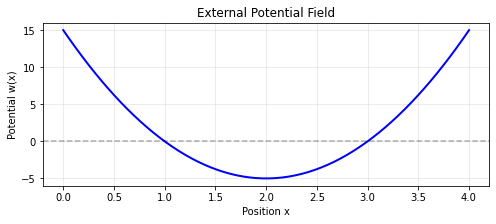

In [5]:
# Plot the potential field we set above
plt.figure(figsize=(8, 3))
plt.plot(x, w_A, 'b-', linewidth=2)
plt.xlabel('Position x')
plt.ylabel('Potential w(x)')
plt.title('External Potential Field')
plt.axhline(y=0, color='k', linestyle='--', alpha=0.3)
plt.grid(True, alpha=0.3)
plt.show()

### Step 3: Compute and Visualize Propagator Evolution

The **chain propagator** $q(\mathbf{r}, s)$ is the central quantity in polymer field theory. It represents the statistical weight of all chain conformations that:
- Start with the first segment anywhere in space
- End with segment $s$ located at position $\mathbf{r}$

**Important:** The contour parameter $s$ is NOT time — it's a position along the chain backbone:
- $s = 0$: Chain start (first monomer)
- $s = 0.5$: Middle of the chain
- $s = 1$: Chain end (last monomer)

The propagator satisfies a diffusion-like equation called the **modified diffusion equation**, where segment index $s$ plays the role of "time".

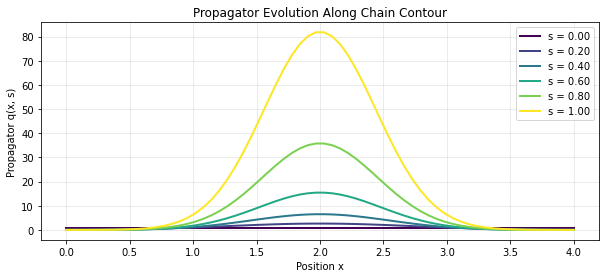

The propagator concentrates where the potential is attractive (negative).


In [6]:
# Start with uniform initial condition
q = np.ones(64)

# Store snapshots
n_steps = 100  # Total chain length = n_steps * ds = 1.0
snapshots = [q.copy()]
snapshot_times = [0]

# Evolve the propagator
for step in range(n_steps):
    q = solver.advance(q, "A")
    if (step + 1) % 20 == 0:
        snapshots.append(q.copy())
        snapshot_times.append((step + 1) * 0.01)

# Plot the evolution
plt.figure(figsize=(10, 4))
colors = plt.cm.viridis(np.linspace(0, 1, len(snapshots)))
for i, (snap, t) in enumerate(zip(snapshots, snapshot_times)):
    plt.plot(x, snap, color=colors[i], label=f's = {t:.2f}', linewidth=2)

plt.xlabel('Position x')
plt.ylabel('Propagator q(x, s)')
plt.title('Propagator Evolution Along Chain Contour')
plt.legend(loc='upper right')
plt.grid(True, alpha=0.3)
plt.show()

print("The propagator concentrates where the potential is attractive (negative).")

## 3. AB Diblock Copolymer in 2D

Now let's simulate a more interesting system: an **AB diblock copolymer** in 2D.

**What is a diblock copolymer?**
- A polymer chain with two chemically distinct blocks (A and B) covalently bonded together
- Example: polystyrene-*b*-polyisoprene (PS-PI)
- When A and B are incompatible, they tend to phase separate into ordered microstructures (lamellae, cylinders, gyroid, etc.)

In field theory, each monomer type experiences its own potential field ($w_A$ and $w_B$), reflecting different chemical environments.

In [ ]:
# Create a 2D solver for AB diblock
solver_2d = PropagatorSolver(
    nx=[32, 32],           # 32x32 grid
    lx=[4.0, 4.0],         # 4x4 domain
    ds=0.01,
    bond_lengths={"A": 1.0, "B": 1.0},
    platform="cpu-fftw"     # Use CPU (or "cuda" for GPU)
)

# Add AB diblock: A block (50%) connected to B block (50%)
# Block format: [type, length, start_node, end_node]
solver_2d.add_polymer(
    volume_fraction=1.0,
    blocks=[
        ["A", 0.5, 0, 1],  # A block from node 0 to node 1
        ["B", 0.5, 1, 2]   # B block from node 1 to node 2
    ]
)

# Create striped potential fields (mimics phase separation)
x_2d = np.linspace(0, 4.0, 32)
y_2d = np.linspace(0, 4.0, 32)
X, Y = np.meshgrid(x_2d, y_2d, indexing='ij')

# A prefers left side, B prefers right side
w_A_2d = 2.0 * np.sin(2 * np.pi * X / 4.0).flatten()
w_B_2d = -w_A_2d  # Opposite preference

# Set the fields (this initializes the internal solver)
solver_2d.set_fields({"A": w_A_2d, "B": w_B_2d})

print(solver_2d.info)

In [ ]:
# Visualize the potentials
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

im0 = axes[0].imshow(w_A_2d.reshape(32, 32).T, origin='lower', 
                     extent=[0, 4, 0, 4], cmap='RdBu_r')
axes[0].set_title('Potential for A monomers')
axes[0].set_xlabel('x')
axes[0].set_ylabel('y')
plt.colorbar(im0, ax=axes[0])

im1 = axes[1].imshow(w_B_2d.reshape(32, 32).T, origin='lower',
                     extent=[0, 4, 0, 4], cmap='RdBu_r')
axes[1].set_title('Potential for B monomers')
axes[1].set_xlabel('x')
axes[1].set_ylabel('y')
plt.colorbar(im1, ax=axes[1])

plt.tight_layout()
plt.show()

In [ ]:
# Evolve propagator for the full chain
q = np.ones(32 * 32)  # Start uniform

# A block: 50 steps
for _ in range(50):
    q = solver_2d.advance(q, "A")

# B block: 50 steps  
for _ in range(50):
    q = solver_2d.advance(q, "B")

# Visualize final propagator
plt.figure(figsize=(6, 5))
plt.imshow(q.reshape(32, 32).T, origin='lower', 
           extent=[0, 4, 0, 4], cmap='hot')
plt.colorbar(label='q(r, s=1)')
plt.title('Final Propagator for AB Diblock')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

print("The propagator shows where the full chain (A-B) is likely to be found.")

## 4. What's Next?

You've learned the basics! Here's where to go next:

### Recommended Learning Order

1. **`NonInteractingChainsInPotentialFields/Diblock.ipynb`** - Detailed AB diblock with concentrations and animations
2. **`NonInteractingChainsInPotentialFields/NonPeriodicBC.ipynb`** - Confined polymers with reflecting/absorbing boundaries
3. **`PolymerFieldTheory/`** - Mathematical foundations of field theory
4. **`SelfConsistentFieldTheory/NaiveSCFT.ipynb`** - Finding equilibrium polymer phases
5. **`SelfConsistentFieldTheory/Cylinder.ipynb`** - Production SCFT with box optimization
6. **`LangevinFieldTheoreticSimulation/`** - Fluctuating field simulations

### Key Concepts to Explore
- **Branched polymers**: Star, comb, and bottle-brush architectures
- **Polymer mixtures**: Multiple polymer species
- **Self-consistent field theory (SCFT)**: Finding equilibrium morphologies
- **Langevin FTS**: Including compositional fluctuations

## Quick Reference

### PropagatorSolver Parameters

| Parameter | Required | Description | Example |
|-----------|----------|-------------|---------|
| `nx` | Yes | Grid points per dimension | `[64]`, `[32, 32]`, `[16, 16, 16]` |
| `lx` | Yes | Box size per dimension | `[4.0]`, `[4.0, 4.0]` |
| `ds` | Yes | Contour step size | `0.01` (typical) |
| `bond_lengths` | Yes | Statistical segment lengths | `{"A": 1.0, "B": 1.2}` |
| `bc` | No | Boundary conditions | `["periodic", "periodic"]`, `["reflecting", "absorbing"]` |
| `method` | No | Solver type | `"pseudospectral"`, `"realspace"` |
| `platform` | No | Computation platform | `"cpu-fftw"`, `"cuda"` |

### Common Polymer Architectures

```python
# Homopolymer
blocks = [["A", 1.0, 0, 1]]

# AB Diblock
blocks = [["A", 0.5, 0, 1], ["B", 0.5, 1, 2]]

# ABC Triblock
blocks = [["A", 0.3, 0, 1], ["B", 0.4, 1, 2], ["C", 0.3, 2, 3]]

# 3-arm star (A-B-A meeting at center node 0)
blocks = [["A", 0.33, 0, 1], ["B", 0.33, 0, 2], ["A", 0.33, 0, 3]]
```